In [18]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/My Drive/Ntu/nndl/CZ4042 Final Project

%cd /content/drive/My Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


### Libraries

### Parse and clean training data

In [19]:
import pandas as pd
import xml.etree.ElementTree as ET

In [20]:
restaurants_reviews_train_path = 'sameval2014/Train_Data_v2.0/Restaurants_Train_v2.xml'
restaurants_reviews_test_path = 'sameval2014/TestB/PhaseB/Restaurants_Test_Data_phaseB.xml'


In [21]:
### Get Train data

tree = ET.parse(restaurants_reviews_train_path)
root = tree.getroot()

# Use this dataframe for multilabel classification
# Must use scikitlearn's multilabel binarizer

labeled_reviews = []
for sentence in root.findall("sentence"):
    entry = {}
    aterms = []
    aspects = []
    if sentence.find("aspectTerms"):
        for aterm in sentence.find("aspectTerms").findall("aspectTerm"):
            aterms.append(aterm.get("term"))
    if sentence.find("aspectCategories"):
        for aspect in sentence.find("aspectCategories").findall("aspectCategory"):
            aspects.append(aspect.get("category"))
    entry["text"], entry["terms"], entry["aspects"]= sentence[0].text, aterms, aspects
    labeled_reviews.append(entry)
train_df = pd.DataFrame(labeled_reviews)
print("there are",len(labeled_reviews),"reviews in this training set")
#    print(sentence.find("aspectCategories").findall("aspectCategory").get("category"))

there are 3041 reviews in this training set


In [22]:
### Get Test data

tree = ET.parse(restaurants_reviews_test_path)
root = tree.getroot()

# Use this dataframe for multilabel classification
# Must use scikitlearn's multilabel binarizer

labeled_reviews = []
for sentence in root.findall("sentence"):
    entry = {}
    aterms = []
    aspects = []
    if sentence.find("aspectTerms"):
        for aterm in sentence.find("aspectTerms").findall("aspectTerm"):
            aterms.append(aterm.get("term"))
    if sentence.find("aspectCategories"):
        for aspect in sentence.find("aspectCategories").findall("aspectCategory"):
            aspects.append(aspect.get("category"))
    entry["text"], entry["terms"], entry["aspects"]= sentence[0].text, aterms, aspects
    labeled_reviews.append(entry)
test_df = pd.DataFrame(labeled_reviews)
print("there are",len(labeled_reviews),"reviews in this test set")
#    print(sentence.find("aspectCategories").findall("aspectCategory").get("category"))

there are 800 reviews in this test set


### Convert aspects to one hot vectors

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_one_hot = pd.DataFrame(mlb.fit_transform(train_df['aspects']),columns=mlb.classes_)
y_test_one_hot = pd.DataFrame(mlb.fit_transform(test_df['aspects']),columns=mlb.classes_)
y_test_one_hot

,ambience,anecdotes/miscellaneous,food,price,service
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,1,0,1,0,0
...,...,...,...,...,...
795,0,0,0,0,1
796,0,0,0,0,1
797,0,0,1,0,1
798,1,0,1,0,0


In [45]:
X_train = list(train_df["text"])
X_test = list(test_df["text"])
y_train = y_train_one_hot.values
y_test = y_test_one_hot.values

### Tokenize words

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### GloVe word embeddings to convert text inputs to their numeric counterparts.

In [47]:
embeddings_dictionary = dict()

glove_file = open('glove/glove.6B.100d.txt', encoding="utf8")

In [48]:
import numpy as np
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Create model

In [49]:
import keras
deep_inputs = keras.Input(shape=(maxlen,))
embedding_layer = keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = keras.layers.LSTM(128)(embedding_layer)
dense_layer_1 = keras.layers.Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = keras.Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [50]:
print(model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 100)           450200    
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 568,093
Trainable params: 117,893
Non-trainable params: 450,200
_________________________________________________________________
None


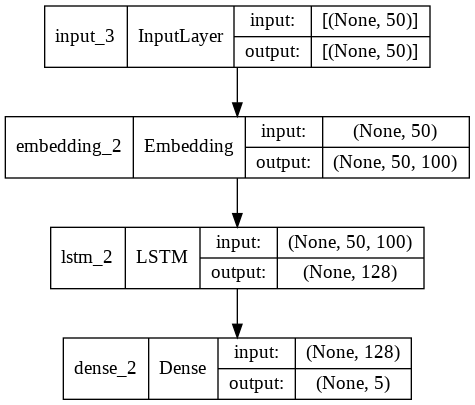

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [52]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)


Epoch 1/20
19/19 [==============================] - 5s 180ms/step - loss: 0.5913 - acc: 0.2562 - val_loss: 0.5192 - val_acc: 0.3892
Epoch 2/20
19/19 [==============================] - 3s 154ms/step - loss: 0.5129 - acc: 0.3803 - val_loss: 0.5197 - val_acc: 0.3908
Epoch 3/20
19/19 [==============================] - 3s 151ms/step - loss: 0.5090 - acc: 0.3836 - val_loss: 0.5143 - val_acc: 0.3810
Epoch 4/20
19/19 [==============================] - 3s 152ms/step - loss: 0.5018 - acc: 0.4301 - val_loss: 0.4936 - val_acc: 0.4598
Epoch 5/20
19/19 [==============================] - 3s 151ms/step - loss: 0.4576 - acc: 0.5440 - val_loss: 0.4331 - val_acc: 0.5862
Epoch 6/20
19/19 [==============================] - 3s 150ms/step - loss: 0.4216 - acc: 0.5954 - val_loss: 0.4203 - val_acc: 0.6125
Epoch 7/20
19/19 [==============================] - 3s 152ms/step - loss: 0.3946 - acc: 0.6225 - val_loss: 0.4170 - val_acc: 0.6125
Epoch 8/20
19/19 [==============================] - 3s 152ms/step - loss: 0.

In [53]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

25/25 [==============================] - 1s 18ms/step - loss: 0.3079 - acc: 0.6888
Test Score: 0.3078707456588745
Test Accuracy: 0.6887500286102295
